<a href="https://colab.research.google.com/github/Pavani-Jyothirmai/Automated-Face-Hand-Segmentation-Using-SAM2-API/blob/main/pipeline_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automated Face & Hand Segmentation Using SAM2 API**

**Install and Import Required Libraries**

In [5]:
pip install ultralytics opencv-python pillow matplotlib requests replicate ultralytics --quiet  numpy==1.26.4 mediapipe

**Upload Image File to Colab**

In [6]:
from google.colab import files
import os

# Upload an image file
uploaded = files.upload()

# Display uploaded file names (optional)
for file_name in uploaded.keys():
    print(f"Uploaded: {file_name}")


Saving pic-2.png to pic-2 (2).png
Uploaded: pic-2 (2).png


**Import Modules & Set Replicate API Token**

In [14]:
import os
import base64
import cv2
import requests
import numpy as np
import replicate
import mediapipe as mp
import matplotlib.pyplot as plt

# Set your Replicate API token
replicate_token = os.getenv("REPLICATE_API_TOKEN")
if replicate_token is None:
    raise ValueError("⚠️ Please set the REPLICATE_API_TOKEN environment variable.")
os.environ["REPLICATE_API_TOKEN"] = replicate_token
replicate_client = replicate.Client(api_token=os.environ["REPLICATE_API_TOKEN"])


**Utility – Expand Bounding Boxes Slightly for Better Masking**

In [21]:
def expand_box(box, img_width, img_height, scale=1.5):
    x1, y1, x2, y2 = box
    cx = (x1 + x2) // 2
    cy = (y1 + y2) // 2
    bw = int((x2 - x1) * scale)
    bh = int((y2 - y1) * scale)
    new_x1 = max(cx - bw // 2, 0)
    new_y1 = max(cy - bh // 2, 0)
    new_x2 = min(cx + bw // 2, img_width - 1)
    new_y2 = min(cy + bh // 2, img_height - 1)
    return [new_x1, new_y1, new_x2, new_y2]


**Detect Faces & Hands Using MediaPipe**

In [17]:
def detect_face_hand_boxes(image_path):
    mp_face = mp.solutions.face_detection
    mp_hands = mp.solutions.hands
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    boxes, labels = [], []

    # 🔍 Detect faces
    with mp_face.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        result = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if result.detections:
            for det in result.detections:
                bbox = det.location_data.relative_bounding_box
                x1 = int(bbox.xmin * w)
                y1 = int(bbox.ymin * h)
                x2 = x1 + int(bbox.width * w)
                y2 = y1 + int(bbox.height * h)
                boxes.append([x1, y1, x2, y2])
                labels.append("face")

    # ✋ Detect hands
    with mp_hands.Hands(static_image_mode=True, max_num_hands=4, min_detection_confidence=0.5) as hands:
        result = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if result.multi_hand_landmarks:
            for i, lm in enumerate(result.multi_hand_landmarks):
                xs = [pt.x for pt in lm.landmark]
                ys = [pt.y for pt in lm.landmark]
                x1 = int(min(xs) * w)
                y1 = int(min(ys) * h)
                x2 = int(max(xs) * w)
                y2 = int(max(ys) * h)
                boxes.append([x1, y1, x2, y2])
                labels.append(f"hand {i+1}")

    return [expand_box(b, w, h) for b in boxes], labels


**Match Segmentation Mask Using IoU**

In [18]:
def get_best_mask_url(box, image_shape, output_masks):
    x1, y1, x2, y2 = box
    h, w = image_shape
    max_iou, best_url = 0, None

    for m in output_masks:
        url = m.url
        mask_resp = requests.get(url)
        mask = cv2.imdecode(np.frombuffer(mask_resp.content, np.uint8), cv2.IMREAD_UNCHANGED)
        if mask is None:
            continue
        if len(mask.shape) == 3:
            mask = mask[:, :, 0]
        mask = cv2.resize(mask, (w, h))
        mask_bin = (mask > 128).astype(np.uint8)

        box_mask = np.zeros_like(mask_bin)
        box_mask[y1:y2, x1:x2] = 1

        intersection = np.logical_and(mask_bin, box_mask).sum()
        union = np.logical_or(mask_bin, box_mask).sum()
        iou = intersection / union if union else 0

        if iou > max_iou:
            max_iou, best_url = iou, url

    return best_url


**Overlay Masks and Bounding Boxes**

In [19]:
def overlay_masks_and_boxes(image_path, boxes, mask_urls, labels):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 🎭 Draw masks (purple)
    for url in mask_urls:
        response = requests.get(url)
        mask = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_UNCHANGED)
        if mask is None:
            continue
        if len(mask.shape) == 3:
            mask = mask[:, :, 0]
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
        mask_bin = (mask > 128).astype(np.uint8)
        purple = np.full_like(image, (138, 43, 226))
        image = np.where(mask_bin[:, :, None], cv2.addWeighted(image, 0.6, purple, 0.4, 0), image)

    # 🧾 Draw white bounding boxes + labels
    for i, (x1, y1, x2, y2) in enumerate(boxes):
        label = labels[i]
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 255), 6)
        cv2.putText(image, label, (x1, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 4)

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Face & Hand Segmentation Output")
    plt.show()


**Run Segmentation Using SAM2 via Replicate API**

Detected objects: [('face', [295, 294, 669, 668]), ('hand 1', [889, 34, 1093, 506]), ('hand 2', [11, 217, 197, 661])]


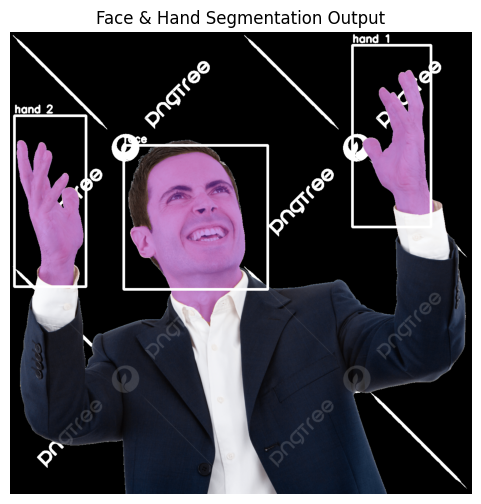

In [22]:
# Automatically pick first uploaded image
image_path = list(uploaded.keys())[0]

# 🔍 Detect face + hands
boxes, labels = detect_face_hand_boxes(image_path)
print("Detected objects:", list(zip(labels, boxes)))

# 📤 Convert image to base64 for SAM2 input
with open(image_path, "rb") as f:
    img_b64 = base64.b64encode(f.read()).decode("utf-8")
data_url = f"data:image/jpeg;base64,{img_b64}"

# 🧠 Get segmentation masks from Replicate's SAM2
image = cv2.imread(image_path)
h, w, _ = image.shape
mask_urls = []

for box in boxes:
    x1, y1, x2, y2 = box
    input_box = [[x1, y1, x2 - x1, y2 - y1]]
    output = replicate_client.run(
        "lucataco/segment-anything-2:be7cbde9fdf0eecdc8b20ffec9dd0d1cfeace0832d4d0b58a071d993182e1be0",
        input={"image": data_url, "input_boxes": input_box}
    )
    best_url = get_best_mask_url(box, (h, w), output)
    if best_url:
        mask_urls.append(best_url)
    else:
        print("❌ No good mask found for:", box)

# 🖼️ Final Visualization
overlay_masks_and_boxes(image_path, boxes, mask_urls, labels)


**Save & Download Final Masked Output Image**

In [23]:
# 🖼️ Convert image from RGB (used by matplotlib) back to BGR (used by OpenCV for saving)
output_image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# 💾 Save the image locally
output_path = "masked_output.jpg"
cv2.imwrite(output_path, output_image_bgr)

# 📥 Provide download link (for Colab)
from google.colab import files
files.download(output_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>